load libraries<br>
---------------------------------------------------------------------------

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.optimize import minimize
from scipy.optimize import Bounds
import datetime as dt
from sklearn.linear_model import LinearRegression
import dataframe_image as dfi

define parameters of investment period start

In [2]:
start_backtesting = np.datetime64("2011-01-01")
end_backtesting = np.datetime64("2021-12-31")

import needed cleaned files<br>
-----------------------------------------------------------------------------

In [3]:
constituents = pd.read_csv("files/index_constituents_data.csv", index_col= 0)
benchmark = pd.read_csv("files/benchmark.csv", index_col= 0)
Gross_Price = pd.read_csv("files/Gross_Prices_EUR.csv", index_col= 0)
Net_Price = pd.read_csv("files/Net_Prices_EUR.csv", index_col= 0)

In [4]:
Gross_Price.index = pd.to_datetime(Gross_Price.index)
Net_Price.index = pd.to_datetime(Net_Price.index)
benchmark.index = pd.to_datetime(benchmark.index)

select stocks to invest in (10 highest dividend yields and 10 lowest dividend yields) & drop<br>
BHP stock for which dividends have not been calculated correctly

In [5]:
constituents = constituents.sort_values(by = "Yield", ascending= False)
constituents = constituents.drop("BHP.L")
stocks = constituents.iloc[np.r_[0:10, 39:49]]

retreive in sample stock prices to calculate returns and var-cov matrix for optimization

In [6]:
Stock_Prices = Gross_Price[stocks.index.to_list()]
in_sample = Stock_Prices[Stock_Prices.index < end_backtesting]

estimate expected returns and var-cov matrix for optimization & delete variables which are not needed anymore (for better overview)

In [7]:
ER = in_sample.pct_change().mean()
S = in_sample.pct_change().cov()

define functions for optimization (variance, return,  negative sharp ratio)<br>
------------------------------------------------------------------------------

In [8]:
def pvar(w, S):
    return (w.T @ S @ w)

In [9]:
def pret(w, ER):
    return (w.T @ ER)

In [10]:
def sharpe(w ,ER, S):
    return -(w.T @ ER)/ ((w.T @ S @ w) ** 0.5)

calculate optimized portfolios<br>
---------------------------------------------------------------------------------------

In [11]:
N = len(ER)
x0 = np.ones(N)/N

set up constraints<br>
first contraint -> total investment = 100% long<br>
second constraint- > Values smaller than - min_weight (shocks which are shorted)<br>
third constraint -> Values larger than min_weight (stock which are longed)<br>
bounds = maximum long and short % for stocks

In [12]:
min_weight = 0.02

In [13]:
cons_multiple = ({"type": "eq", "fun" : lambda x: np.sum(x) - 1},
                {"type": "ineq", "fun" : lambda x: -min_weight -x[10:20]},
                {"type": "ineq", "fun" : lambda x: x[0:10]- min_weight})

In [14]:
bounds = Bounds(-0.2, 0.2)

only constraint for unconstrained portfolio --> Total stock weights == 100%

In [15]:
cons_simple = ({"type": "eq", "fun" : lambda x: np.sum(x) - 1})

calculate optimized values (GMVP and MSRP constrained and unconstrained)

In [16]:
GMVP_const = minimize(pvar, x0, method='SLSQP', args=S, constraints = cons_multiple,
                      options={'disp': True, 'ftol': 1e-9}, bounds = bounds)
GMVP_unconst = minimize(pvar, x0, method = "SLSQP", args = S,constraints = cons_simple,
                        options={'disp': True, 'ftol': 1e-9})
MSRP_const = minimize(sharpe, x0, method='SLSQP', args=(ER, S), constraints=cons_multiple,
                      options={'disp': True, 'ftol': 1e-9}, bounds = bounds)
MSRP_unconst = minimize(sharpe, x0, method='SLSQP', args=(ER,S), constraints = cons_simple,
                        options={'disp': True, 'ftol': 1e-9})

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.00018520068752565962
            Iterations: 36
            Function evaluations: 756
            Gradient evaluations: 36
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.00011595972625592764
            Iterations: 24
            Function evaluations: 504
            Gradient evaluations: 24
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.07287612274278762
            Iterations: 16
            Function evaluations: 336
            Gradient evaluations: 16
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.18343376648116225
            Iterations: 34
            Function evaluations: 717
            Gradient evaluations: 34


complete data set of selected stocks with calculated constrained MSRP values & export for presentation

In [17]:
stocks["weights"] = MSRP_const.x
stocks["weights_unconst"] = MSRP_unconst.x
# dfi.export(stocks, "plots/selected_portfolio_characteristics.png")

C:\Users\User\AppData\Local\Temp\ipykernel_11748\848017602.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks["weights"] = MSRP_const.x
C:\Users\User\AppData\Local\Temp\ipykernel_11748\848017602.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks["weights_unconst"] = MSRP_unconst.x


###########################################################################<br>
Calculate Strategy and Benchmark Returns in and out of Sample<br>
###########################################################################

calculate change of correlation  matrix in and out of sample

In [18]:
out_sample_cor = Stock_Prices[Stock_Prices.index > end_backtesting].pct_change().corr()
in_sample_cor =  Stock_Prices[Stock_Prices.index < end_backtesting].pct_change().corr()

In [19]:
rel_cor = out_sample_cor / in_sample_cor
pd.DataFrame(rel_cor).to_csv("files/correlation_change.csv")

DAILY Net Returns / Gross Returns / Net & Gross for long & Short individually over total period

In [20]:
Net_Returns = Net_Price[stocks.index].pct_change() + 1
Gross_Returns = Gross_Price[stocks.index].pct_change() + 1
Gross_Returns_short = Gross_Price[stocks[stocks.weights < 0].index].pct_change() + 1
Gross_Returns_long = Gross_Price[stocks[stocks.weights > 0].index].pct_change() + 1

in sample returns CUMULATIVE

1. Daily Returns over in Sample Period

In [21]:
in_sample_net = Net_Returns[Net_Returns.index < end_backtesting]
in_sample_gross = Gross_Returns[Gross_Returns.index < end_backtesting]
in_sample_short_gross = Gross_Returns_short[Gross_Returns_short.index < end_backtesting]
in_sample_long_gross = Gross_Returns_long[Gross_Returns_long.index < end_backtesting]

2. standardize initial stock prices to 1, multiply by strategy weights

In [22]:
in_sample_net.iloc[0] = MSRP_const.x
in_sample_gross.iloc[0] = MSRP_const.x
in_sample_long_gross.iloc[0] = stocks.weights[stocks.weights > 0] / stocks.weights[stocks.weights > 0].sum()
in_sample_short_gross.iloc[0] = np.abs(stocks.weights[stocks.weights < 0]) / np.abs(stocks.weights[stocks.weights < 0].sum())

C:\Users\User\AppData\Local\Temp\ipykernel_11748\3480935202.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  in_sample_net.iloc[0] = MSRP_const.x
C:\Users\User\AppData\Local\Temp\ipykernel_11748\3480935202.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  in_sample_gross.iloc[0] = MSRP_const.x
C:\Users\User\AppData\Local\Temp\ipykernel_11748\3480935202.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  in_sample_long_gross.iloc[0

3. take cumulative product of initial investment and daily returns to get relative values of stocks in strategy over time<br>
sum up all values and get total value of strategy over time (indexed to 1 at start)

In [23]:
in_sample_net = in_sample_net.cumprod().sum(axis = 1)
in_sample_gross = in_sample_gross.cumprod().sum(axis = 1)
in_sample_long_gross = in_sample_long_gross.cumprod().sum(axis = 1)
in_sample_short_gross = in_sample_short_gross.cumprod().sum(axis = 1)

4. combine all returns to data frame

In [24]:
in_sample = pd.DataFrame({"strategy_net": in_sample_net, "strategy_gross": in_sample_gross,
                          "gross_long": in_sample_long_gross, "gross_short": in_sample_short_gross},
                         index = in_sample_net.index)

5. add relative benchmark returns to data frame

In [25]:
in_sample = in_sample.join(benchmark)
in_sample[["benchmark_gross", "benchmark_net"]] = in_sample[["benchmark_gross", "benchmark_net"]].div(in_sample[["benchmark_gross", "benchmark_net"]].iloc[0])

out of sample returns CUMULATIVE

1. Daily Returns over out of Sample Period

In [26]:
out_sample_net = Net_Returns[Net_Returns.index > end_backtesting]
out_sample_gross = Gross_Returns[Gross_Returns.index > end_backtesting]
out_sample_short_gross = Gross_Returns_short[Gross_Returns_short.index > end_backtesting]
out_sample_long_gross = Gross_Returns_long[Gross_Returns_long.index > end_backtesting]

2. standardize initial stock prices to 1, multiply by strategy weights

In [27]:
out_sample_net.iloc[0] = MSRP_const.x
out_sample_gross.iloc[0] = MSRP_const.x
out_sample_long_gross.iloc[0] = stocks.weights[stocks.weights > 0] / stocks.weights[stocks.weights > 0].sum()
out_sample_short_gross.iloc[0] = np.abs(stocks.weights[stocks.weights < 0]) / np.abs(stocks.weights[stocks.weights < 0].sum())

C:\Users\User\AppData\Local\Temp\ipykernel_11748\3419972617.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_sample_net.iloc[0] = MSRP_const.x
C:\Users\User\AppData\Local\Temp\ipykernel_11748\3419972617.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_sample_gross.iloc[0] = MSRP_const.x
C:\Users\User\AppData\Local\Temp\ipykernel_11748\3419972617.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_sample_long_gross.ilo

3. take cumulative product of initial investment and daily returns to get relative values of stocks in strategy over time<br>
sum up all values and get total value of strategy over time (indexed to 1 at start)

In [28]:
out_sample_net = out_sample_net.cumprod().sum(axis = 1)
out_sample_gross = out_sample_gross.cumprod().sum(axis = 1)
out_sample_long_gross = out_sample_long_gross.cumprod().sum(axis = 1)
out_sample_short_gross = out_sample_short_gross.cumprod().sum(axis = 1)

4. combine all returns to data frame

In [29]:
out_sample = pd.DataFrame({"strategy_net": out_sample_net, "strategy_gross": out_sample_gross,
                           "long_gross": out_sample_long_gross, "short_gross": out_sample_short_gross},
                         index = out_sample_gross.index)

5. add relative benchmark returns to data frame

In [30]:
out_sample = out_sample.join(benchmark)
out_sample[["benchmark_gross", "benchmark_net"]] = out_sample[["benchmark_gross", "benchmark_net"]].div(out_sample[["benchmark_gross", "benchmark_net"]].iloc[0])

Calculate contribution of all stocks to excess / shortfall return of strategy vs. Benchmark

Calculate returns over out of sample periods for all stocks in index

In [31]:
out_sample_all = Gross_Price[Gross_Price.index > end_backtesting]
out_sample_all = out_sample_all.pct_change() + 1
out_sample_all = out_sample_all.fillna(1).cumprod()
out_return_all = out_sample_all.iloc[len(out_sample_all.index)-1].div(out_sample_all.iloc[0]) - 1

###########################################################################<br>
Create Plots<br>
###########################################################################

calculate excess return contribution as (Weight Strategy - Weigh Index) * Return

In [32]:
ret_contrib = constituents.join(stocks["weights"]).fillna(0)
ret_contrib["diff_weights"] = ret_contrib["weights"] - ret_contrib["index_weights"]
ret_contrib = ret_contrib.join(pd.DataFrame(out_return_all))
ret_contrib = ret_contrib.rename(columns = {0: "return"})
ret_contrib["diff_return"] = ret_contrib["diff_weights"] * ret_contrib["return"]

plot and save results

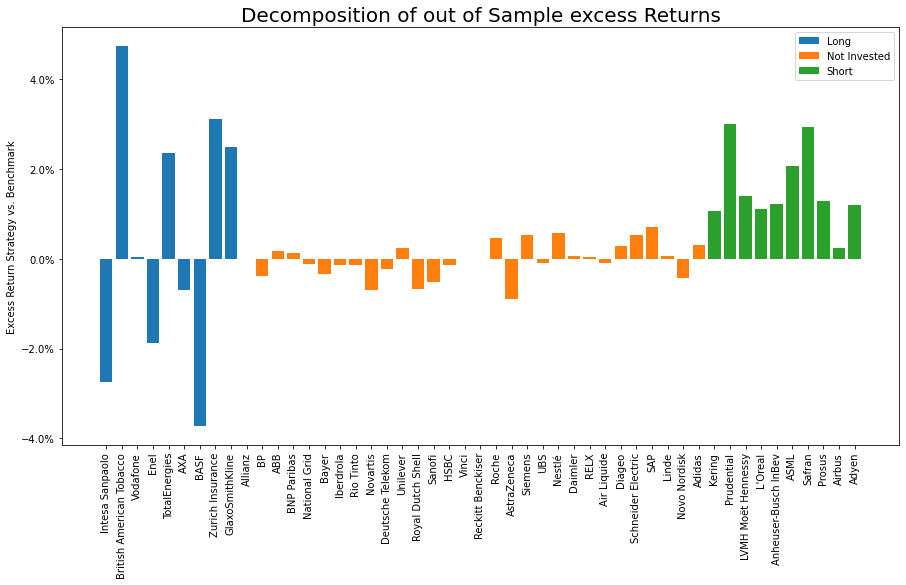

In [33]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
plt.bar(ret_contrib.Name[0:10], ret_contrib.diff_return[0:10])
plt.bar(ret_contrib.Name[10:39], ret_contrib.diff_return[10:39])
plt.bar(ret_contrib.Name[39:49], ret_contrib.diff_return[39:49])
plt.legend(["Long", "Not Invested", "Short"])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.title("Decomposition of out of Sample excess Returns", size = 20)
plt.ylabel("Excess Return Strategy vs. Benchmark")
plt.subplots_adjust(bottom = 0.3)
plt.xticks(rotation=90)
plt.savefig("plots/excess_return_breakdown.png")

out of sample strategy vs. benchmark

Text(0.5, 0, 'Date')

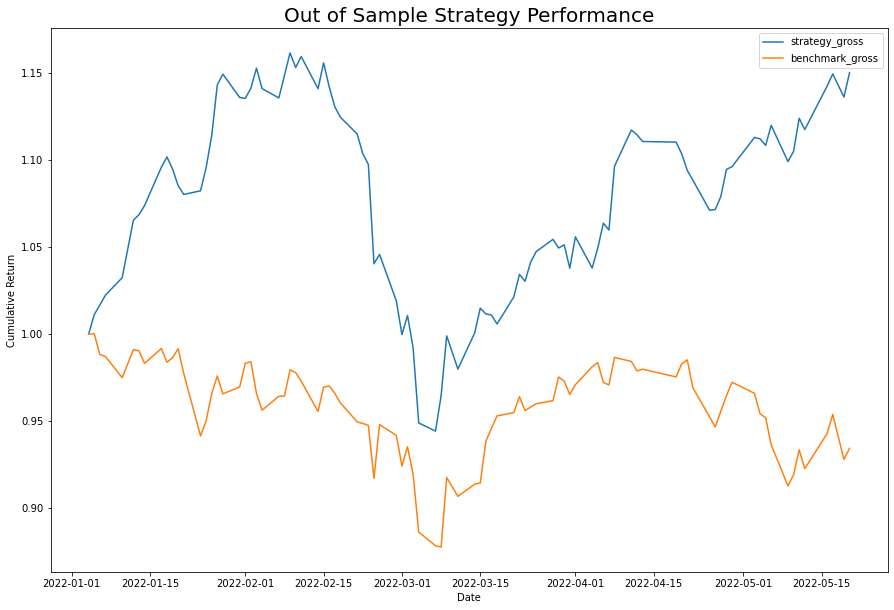

In [34]:
fig = plt.figure(figsize=(15, 10))
plt.plot(out_sample[["strategy_gross", "benchmark_gross"]])
plt.legend(out_sample[["strategy_gross", "benchmark_gross"]].columns)
plt.title("Out of Sample Strategy Performance", size = 20)
plt.ylabel("Cumulative Return")
plt.xlabel("Date")

In [35]:
plt.savefig("plots/outofsample_performance.png")

<Figure size 432x288 with 0 Axes>

in sample strategy vs. benchmark

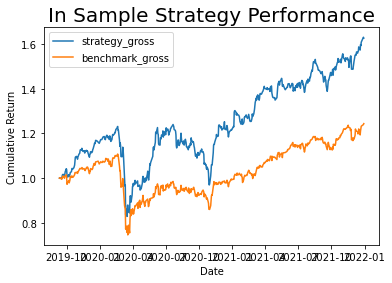

In [36]:
plt.plot(in_sample[["strategy_gross", "benchmark_gross"]])
plt.legend(in_sample[["strategy_gross", "benchmark_gross"]].columns)
plt.title("In Sample Strategy Performance", size = 20)
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.savefig("plots/insample_performance.png")

show strategy returns net vs. gross (shows importance of dividend yield)

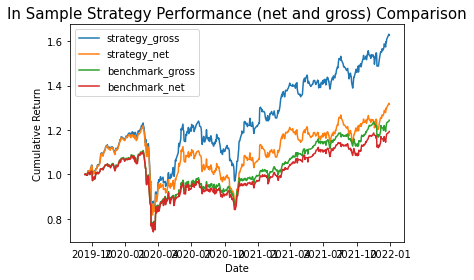

In [37]:
plt.plot(in_sample[["strategy_gross", "strategy_net", "benchmark_gross", "benchmark_net"]])
plt.legend(in_sample[["strategy_gross", "strategy_net", "benchmark_gross", "benchmark_net"]].columns)
plt.title("In Sample Strategy Performance (net and gross) Comparison", size = 15)
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.savefig("plots/insample_performance_netgross.png")

plot out of sample short vs long (shows that we outperformed benchmark in both portfolios -> show detailed breakdown)

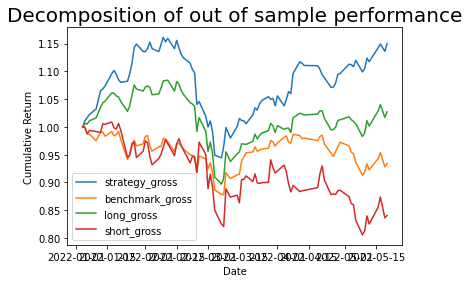

In [38]:
plt.plot(out_sample[["strategy_gross", "benchmark_gross", "long_gross", "short_gross"]])
plt.legend(out_sample[["strategy_gross", "benchmark_gross", "long_gross", "short_gross"]].columns)
plt.title("Decomposition of out of sample performance", size = 20)
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.savefig("plots/outofsamlpe_brekdown.png")

plot weights for different optimization techniques (GMVP, MSRP (constrained and unconstrained)<br>
XXXXXXXXXXXX

plot dividend yields of picked stocks

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, 

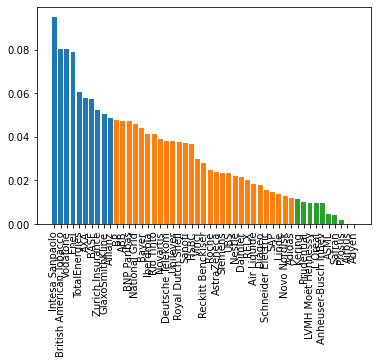

In [39]:
plt.bar(constituents.Name[0:10], height = constituents.Yield[0:10])
plt.bar(constituents.Name[10:39], height = constituents.Yield[10:39])
plt.bar(constituents.Name[39:49], height = constituents.Yield[39:49])
plt.xticks(rotation=90)

plot strategy weights vs index weights vs unconstrained optimization weights

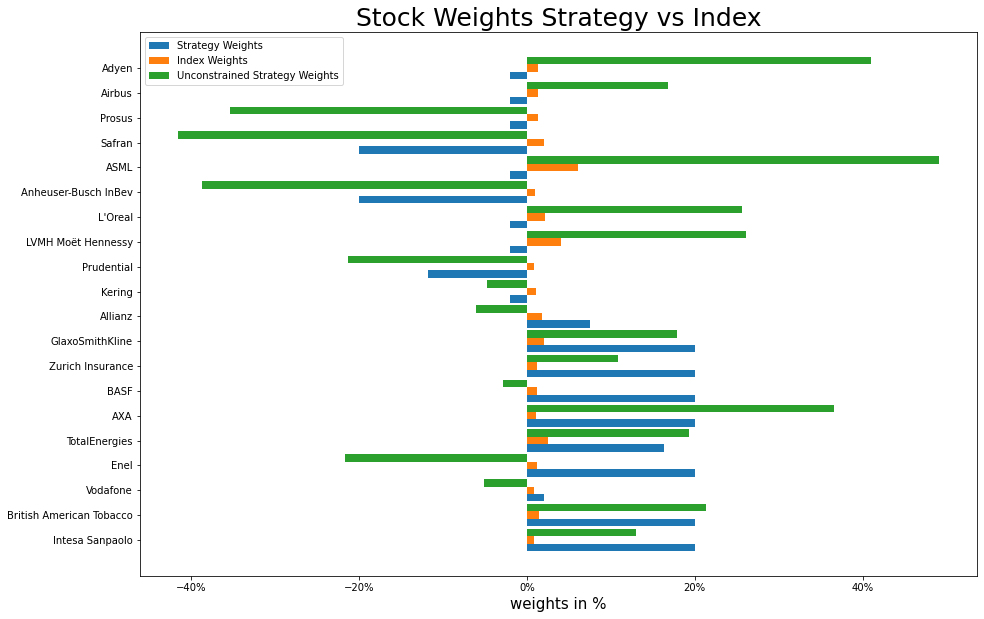

In [40]:
width = 0.3
fig, ax = plt.subplots(figsize = (15,10))
ind = np.arange(len(stocks))
ax.barh(ind, stocks.weights, width, label = "Strategy Weights")
ax.barh(ind + width, stocks.index_weights, width, label = "Index Weights")
ax.barh(ind + 2* width, stocks.weights_unconst, width, label = "Unconstrained Strategy Weights")
ax.set(yticks = ind + width, yticklabels = stocks.Name)
ax.legend(prop={'size': 10})
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.title("Stock Weights Strategy vs Index", size = 25)
plt.xlabel("weights in %", size = 15)
plt.savefig("plots/strategy_weights.png")

In [41]:
country_weights = stocks[["Country", "weights"]].groupby(by = "Country").sum()

plot currencies

In [42]:
constituents = constituents.join(stocks["weights"]).fillna(0)
currency_weights_strategy = constituents[["Currency", "weights"]].groupby(by = "Currency").sum()
currency_weights_index = constituents[["Currency", "index_weights"]].groupby(by = "Currency").sum()

In [43]:
currency_weights = currency_weights_index.join(currency_weights_strategy).fillna(0)
currency_weights = currency_weights.rename(index = {"GBp": "GBP"})

pie chart of currency weights in strategy

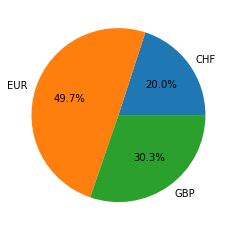

In [44]:
plt.pie(currency_weights.weights.loc[currency_weights.weights > 0], labels= currency_weights.weights.loc[currency_weights.weights > 0].index, autopct='%1.1f%%')
plt.savefig("currency_pie_strategy.png")

plot currency weights stragety vs index

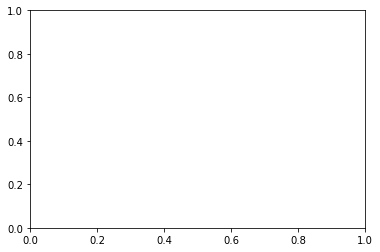

In [45]:
width = 0.4
fig, ax = plt.subplots()
ind = np.arange(len(currency_weights_index))

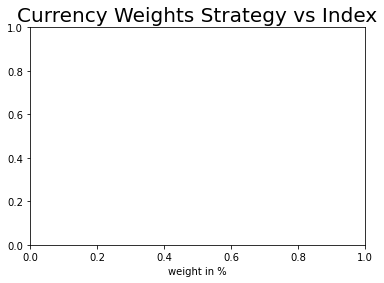

In [46]:
ax.barh(ind, currency_weights.weights, width, label = "Strategy Weights")
ax.barh(ind + width, currency_weights.index_weights, width, label = "Index Weights")
ax.set(yticks = ind + width, yticklabels = currency_weights.index)
ax.legend(["Strategy", "Index"])
plt.title("Currency Weights Strategy vs Index", size = 20)
plt.xlabel("weight in %")
plt.savefig("curency_comparison.png")

plot industries

In [47]:
sector_weights_strategy = stocks[["Sector", "weights"]].groupby(by = "Sector").sum()
sector_weights_index = constituents[["Sector", "index_weights"]].groupby(by = "Sector").sum()
sector_weights = sector_weights_index.join(sector_weights_strategy)

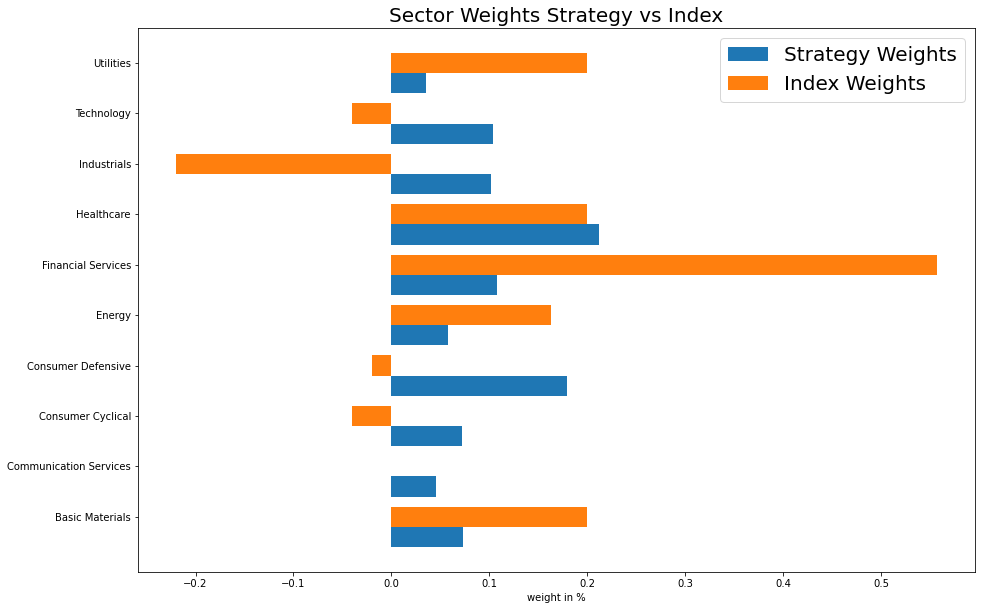

In [48]:
width = 0.4
fig, ax = plt.subplots(figsize=(15, 10))
ind = np.arange(len(sector_weights))
ax.barh(ind, sector_weights.index_weights, width, label = "Strategy Weights")
ax.barh(ind + width, sector_weights.weights, width, label = "Index Weights")
ax.set(yticks = ind + width, yticklabels = sector_weights.index)
ax.legend(prop = {"size": 20})
plt.xlabel("weight in %")
plt.title("Sector Weights Strategy vs Index", size = 20)
plt.savefig("sector_weights.png")

plot ftse all world high dividend index vs nasdaq 100 vs msci world(both quoted in euros)

In [49]:
prices = yf.download(tickers = ["VHYL.AS", "EXXT.DE", "IWDA.AS"], start = "2022-01-01", end = dt.date.today())
prices = prices["Adj Close"]
prices = prices.div(prices.iloc[0])
prices = prices.rename(columns = {"EXXT.DE": "Nasdaq 100", "IWDA.AS": "MSCI World", "VHYL.AS": "FTSE All World High Dividend"})

[*********************100%***********************]  3 of 3 completed


Text(0.5, 0, 'Date')

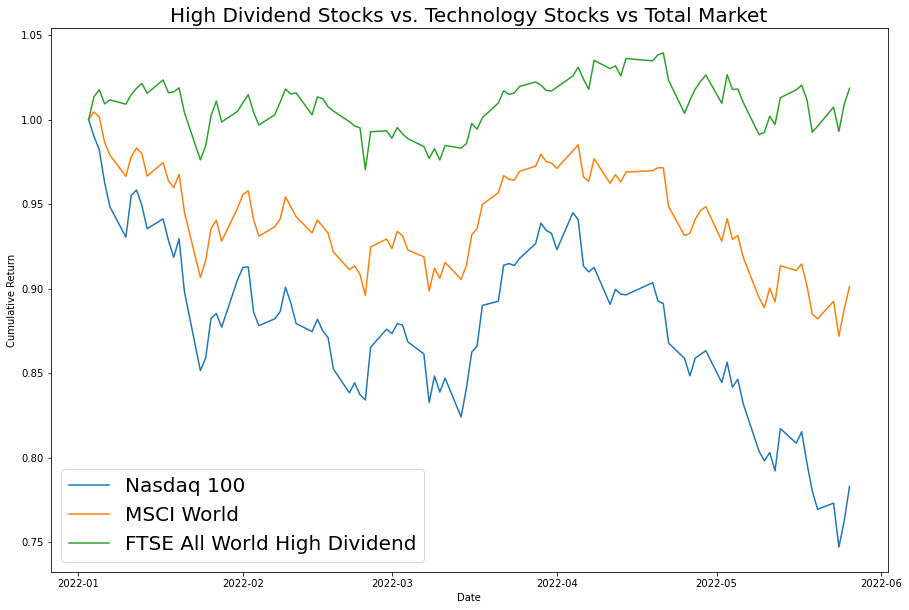

In [50]:
plt.figure(figsize=(15, 10))
plt.plot(prices)
plt.title("High Dividend Stocks vs. Technology Stocks vs Total Market", size = 20)
plt.legend(prices.columns,  prop={'size': 20})
plt.ylabel("Cumulative Return")
plt.xlabel("Date")

In [51]:
plt.savefig("comparison.png")

<Figure size 432x288 with 0 Axes>

############################################################################<br>
Calculate Performance Ratios of Strategy and Index (in and out of Sample)<br>
###########################################################################

inputs: ER = expected daily returns<br>
Sd = expected daily standard deviation of reurns<br>
annzalized risk free rate<br>
number of days over which sharp ratio shall be calculated

In [52]:
def sharp_ratio(ER, Sd, Rf, days):
    SR = (ER-Rf/days)/Sd * m.sqrt(days)
    return(SR)

In [53]:
rf_rate = 0

In [54]:
SR_bm_in_sample = sharp_ratio(ER = in_sample["benchmark_gross"].pct_change().mean()
                              , Sd = in_sample["benchmark_gross"].pct_change().std(),
                              Rf = rf_rate, days = 250)

In [55]:
SR_bm_out_sample = sharp_ratio(ER = out_sample["benchmark_gross"].pct_change().mean(),
                               Sd = out_sample["benchmark_gross"].pct_change().std(),
                               Rf = rf_rate, days = 250)

In [56]:
SR_strategy_in_sample = sharp_ratio(ER = in_sample["strategy_gross"].pct_change().mean(),
                                    Sd = in_sample["strategy_gross"].pct_change().std(),
                                    Rf = rf_rate, days = 250)

In [57]:
SR_strategy_out_sample = sharp_ratio(ER = out_sample["strategy_gross"].pct_change().mean(),
                                     Sd = out_sample["strategy_gross"].pct_change().std(),
                                     Rf = rf_rate, days = 250)

calculate yearly volatility over observation period

In [58]:
vol_BM_in = m.sqrt(in_sample["benchmark_gross"].pct_change().var() * 250)
vol_BM_out = m.sqrt(out_sample["benchmark_gross"].pct_change().var() * 250)
vol_strategy_in = m.sqrt(in_sample["strategy_gross"].pct_change().var() * 250)
vol_strategy_out = m.sqrt(out_sample["strategy_gross"].pct_change().var() * 250)

total returns

In [59]:
# ret_BM_in
# ret_BM_out
# ret_strategy_in
# ret_strategy_out

calculat monthly betas and alphas for strategy

daily returns in sample

In [60]:
daily_returns_strategy_in = in_sample["strategy_gross"].pct_change().fillna(0) + 1
daily_returns_BM_in = in_sample["benchmark_gross"].pct_change().fillna(0) + 1

In [61]:
daily_returns_strategy_out = out_sample["strategy_gross"].pct_change().fillna(0) + 1
daily_returns_BM_out = out_sample["benchmark_gross"].pct_change().fillna(0) + 1

convert to monthly returns

In [62]:
y_in = daily_returns_strategy_in.groupby(pd.Grouper(freq='M')).prod().to_numpy().reshape((-1,1)) -1
x_in = daily_returns_BM_in.groupby(pd.Grouper(freq='M')).prod().to_numpy().reshape((-1,1)) -1

In [63]:
y_out = daily_returns_strategy_out.groupby(pd.Grouper(freq='M')).prod().to_numpy().reshape((-1,1)) -1
x_out = daily_returns_BM_out.groupby(pd.Grouper(freq='M')).prod().to_numpy().reshape((-1,1)) -1

calculate regression parameters

In [64]:
model_in = LinearRegression().fit(x_in,y_in)
model_out = LinearRegression().fit(x_out, y_out)

retreive beta and alpha

In [65]:
in_sample_beta = model_in.coef_
in_sample_alpha = model_in.intercept_

In [66]:
out_sample_beta = model_out.coef_
out_sample_alpha = model_out.intercept_

plot regression line (MODIFY)

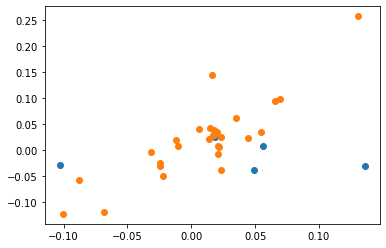

In [67]:
plt.scatter(y_out, x_out)
plt.scatter(x_in, y_in)

calculate maximum drawdown

In [68]:
maxdd_BM_in = np.min(in_sample.diff().cumsum().benchmark_gross)
maxdd_BM_out =np.min(out_sample.diff().cumsum().benchmark_gross)
maxdd_strategy_in  = np.min(in_sample.diff().cumsum().strategy_gross)
maxdd_strategy_out = np.min(out_sample.diff().cumsum().strategy_gross)

calculate performance ratios for short and long portfolios

In [69]:
stocks_short = stocks[stocks.weights <0]
stocks_long = stocks[stocks.weights > 0]

dividend yield

In [70]:
div_yield_long = (stocks_long.weights / stocks_long.weights.sum() * stocks_long.Yield).sum()
div_yield_short = (stocks_short.weights.abs()/ stocks_short.weights.abs().sum() * stocks_short.Yield).sum()
div_yield_index = (constituents.index_weights * constituents.Yield).sum()

trailing PE Ratio, forward PE, PB Ratio

get all stocks and join strategy weights

In [71]:
index = constituents.join(stocks[["weights"]])

ValueError: columns overlap but no suffix specified: Index(['weights'], dtype='object')

1. remove stocks where ratios are not given

In [ ]:
index = index[index.Trailing_PE.notna()]
index = index[index.Forward_PE.notna()]

NameError: name 'index' is not defined

2. set PE ratios above 60 to 60, set PB ratios above 25 to 25

In [ ]:
index.Trailing_PE = np.where(index.Trailing_PE > 60, 60, index.Trailing_PE)
index.Forward_PE = np.where(index.Forward_PE > 60, 60, index.Forward_PE)
index.PB_Ratio = np.where(index.PB_Ratio > 25, 25, index.PB_Ratio)

3. separate long and short stocks from strategy to calculate ratios separately

In [ ]:
short = index.loc[stocks_short.index]
long = index.loc[stocks_long.index]

calculate Trailing PE

In [ ]:
PE_long = (long.weights / long.weights.sum() * long.Trailing_PE).sum()
PE_short = (short.weights / short.weights.sum() * short.Trailing_PE).sum()
PE_index = (index.index_weights * index.Trailing_PE).sum()

calculate forward PE

In [ ]:
PE_fwd_long = (long.weights / long.weights.sum() * long.Forward_PE).sum()
PE_fwd_short = (short.weights / short.weights.sum() * short.Forward_PE).sum()
PE_fwd_index = (index.index_weights * index.Forward_PE).sum()

calculate PB Ratio

In [ ]:
PB_long = (long.weights / long.weights.sum() * long.PB_Ratio).sum()
PB_short = (short.weights / short.weights.sum() * short.PB_Ratio).sum()
PB_index = (index.index_weights * index.PB_Ratio).sum()

assemble metrics dataframe

In [ ]:
ratios_short = {"Yield": div_yield_short, "Price_Book": PB_short, "Trailing_PE": PE_short,
                "Forward_PE": PE_fwd_short}
ratios_long = {"Yield": div_yield_long, "Price_Book": PB_long, "Trailing_PE": PE_long,
                "Forward_PE": PE_fwd_long}

In [ ]:
ratios_index = {"Yield": div_yield_index, "Price_Book": PB_index, "Trailing_PE": PE_index,
                "Forward_PE": PE_fwd_index}

In [ ]:
ratios_table = pd.DataFrame({"Portfolio Short":ratios_short, "Portfolio Long": ratios_long, "Index": ratios_index})
ratios_table = ratios_table.round(3)

export table

In [ ]:
dfi.export(ratios_table, "portfolio_characteristics.png")

also check for correlation breakdowns etc...

simulate constrained efficient frontier!<br>
------------------------------------------------------------------------------

calculate volatility and expected return of GMVP and MSRP constrained

In [ ]:
GMVP_const_ER = pret(w = GMVP_const.x, ER = ER) * 250
GMVP_const_VAR = m.sqrt(pvar(w = GMVP_const.x, S = S) * 250)
MSRP_const_ER =  pret(w = MSRP_const.x, ER = ER) * 250
MSRP_const_VAR = m.sqrt(pvar(w = MSRP_const.x, S = S) * 250)

simulate minimum varaince frontier by minimizing the negative of the expected portfolio return<br>
given a deterministic variance and the same restrictions as above.<br>
we loop over an array of variances and can thus numerically get the MVF

In [ ]:
def pret_sim(w, ER):
    return (-(w.T @ ER))

variances to loop over

In [ ]:
a = np.arange(0.1, 0.6, 0.01)
bounds = Bounds(-0.2, 0.2)

initialize lists to store results in

In [ ]:
MVF_var_const = []
MVF_ret_const = []

loop over variances and maximize expected return given that portfolio variance = given variance

In [ ]:
for i in a:
    max_var = i
    cons = ({"type": "eq", "fun" : lambda x: np.sum(x) - 1},
            {"type": "eq", "fun" : lambda x: m.sqrt((x.T @ S @ x)* 250) - max_var},
            {"type": "ineq", "fun": lambda x: -min_weight - x[10:20]},
            {"type": "ineq", "fun": lambda x: x[0:10] - min_weight})
    maximized = minimize(pret_sim, x0, method='SLSQP', args= ER, options={'disp': True, 'ftol': 1e-9}, constraints=cons, bounds = bounds)

    ##only store result if optimization was successful!
    if maximized.success:
        MVF_var_const.append(i)
        MVF_ret_const.append(maximized.fun * -250)
    else:
        continue

simulate random constrained portfolios<br>
we simulate random portfolios which fulfil all restrictions by minimzing a "random" function which uses a random<br>
array and the modulus to generate different portfolios<br>
----------------------------------------------------------------------------------------

In [ ]:
random_portfolio = []

In [ ]:
def rand_funct(x,y):
    return ((x % y)/y).sum()

In [ ]:
cons = ({"type": "eq", "fun" : lambda x: np.sum(x) - 1},
        {"type": "ineq", "fun": lambda x: -min_weight - x[10:20]},
        {"type": "ineq", "fun": lambda x: x[0:10] - min_weight})

In [ ]:
i = 0
while i < 60:
    y = np.random.uniform(low= 0, high=1, size=20)
    MSRP_sim = minimize(rand_funct, x0, method='SLSQP', args= y, constraints=cons, options={'disp': True, 'ftol': 1e-9}, bounds = bounds)
    i = i + 1

    ##only store successful optimizations
    if MSRP_sim.success:
        random_portfolio.append(MSRP_sim.x)
    else:
        continue

In [ ]:
MVF_randvar_const = []
MVF_randret_const = []

calculate return and variance (yearly) from calculated "random" portfolios

In [ ]:
for i in range(len(random_portfolio)):
    exp_return = pret(w = random_portfolio[i], ER = ER)
    exp_var = pvar(w = random_portfolio[i], S = S)
    exp_return_year = exp_return * 250
    exp_var_year = m.sqrt(exp_var * 250)
    MVF_randvar_const.append(exp_var_year)
    MVF_randret_const.append(exp_return_year)

plot results

In [ ]:
MVF_var_const.insert(0, GMVP_const_VAR)
MVF_ret_const.insert(0, GMVP_const_ER)
CAL_x = np.linspace(0, MSRP_const_VAR + 0.2, 50, endpoint=True)
SR_MSRP = MSRP_const_ER / MSRP_const_VAR
CAL_y = 0 + SR_MSRP*CAL_x

In [ ]:
frontier_points = pd.DataFrame({"variance": MVF_var_const, "return": MVF_ret_const})

In [ ]:
max_ret_index = frontier_points["return"].idxmax()

plot part that goes down again grey!

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(frontier_points.variance.iloc[0:max_ret_index + 1], frontier_points["return"].iloc[0:max_ret_index + 1])
plt.plot(frontier_points.variance.iloc[max_ret_index: len(frontier_points)],
         frontier_points["return"].iloc[max_ret_index: len(frontier_points)], color = "grey", ls =  "--")

In [ ]:
plt.scatter(MVF_randvar_const, MVF_randret_const)
plt.scatter(GMVP_const_VAR, GMVP_const_ER, s = 70)
plt.scatter(MSRP_const_VAR, MSRP_const_ER, s = 70)
plt.plot(CAL_x, CAL_y)
plt.xlim([0,0.4])
plt.ylim([0,0.3])
plt.title("Minimum Variance Frontier Simulated", size = 22)
plt.xlabel("Volatility", size = 12)
plt.ylabel("Return", size = 12)
plt.legend(["Minimum Variance Frontier", "?", "Capital Allocation Line","random portfolios", "GMVP", "MSRP"],
           prop={'size': 10})
plt.savefig("minimumvariancefrontier.png")